In [29]:
%matplotlib inline
import numpy as np
from astropy.io import fits
import matplotlib.pylab as plt

## load spec data 
## header names in keck_headers.npy
boo2list = fits.open('alldata_Boo2.fits')
boo2_spec = boo2list[1]
erilist = fits.open('alldata_Eri.fits')
eri_spec = erilist[1]

## load phot data 
## id  ra  dec  g  gerr  r  rerr  chi  sharp  rd  l  b  egr  ag  ar
boo2_phot = np.genfromtxt('boo2_marla.db') 
eri_phot = np.genfromtxt('eridanus_marla.db')

## load MW contaminant file
## Dist Mv CL Typ LTef logg Age Mass u-g g-r r-i i-z u mux muy Vr UU VV WW [Fe/H] l b Av Mbol
def mw_contaminant_cmd(mwfile):
    mw = np.genfromtxt(mwfile, usecols = (0,8,9,12))
    mw_mu = mw[:,3] 
    mw_mg = mw_mu-mw[:,1] #g = u - (u-g)
    mw_g_r = mw[:,2]
    mw_mr = mw_mg - mw_g_r #r = g - (g-r)
    return mw_mr, mw_g_r

## import Padova 2002 isochrones
## each of these has an age of 12 Gyr
## Kroupa IMF
## I used the default TP-AGB model, PARSEC version 1.2S
## Z log(age/yr) M_ini M_act logL/Lo logTe logG mbol u g r i z int_IMF stage
isochrone_1_0 = np.genfromtxt('isochrone_12gyr_fe_h_1_0.dat') #[Fe/H] = -1.0
isochrone_1_1 = np.genfromtxt('isochrone_12gyr_fe_h_1_1.dat') #[Fe/H] = -1.1
isochrone_1_2 = np.genfromtxt('isochrone_12gyr_fe_h_1_2.dat') #[Fe/H] = -1.5
isochrone_1_5 = np.genfromtxt('isochrone_12gyr_fe_h_1_5.dat') #[Fe/H] = -1.5
isochrone_1_9 = np.genfromtxt('isochrone_12gyr_fe_h_1_9.dat') #[Fe/H] = -1.9

##a couple 11 Gyr isochrones for Eridanus
isochrone_1_0_11 = np.genfromtxt('isochrone_11gyr_fe_h_1_0.dat') #[Fe/H] = -1.0
isochrone_1_1_11 = np.genfromtxt('isochrone_11gyr_fe_h_1_1.dat') #[Fe/H] = -1.1

##Reddening corrections
boo2_red = 0.031 
eri_red = 0.021

## Making sure two tracks on isochrones not connected
def colour_jump(isochrone, col1, col2):
    colour = isochrone[:,col1]-isochrone[:,col2]
    dcol = np.zeros(colour.shape)
    for i in xrange(len(dcol)-1):
        dcol[i]=colour[i]-colour[i+1]
    index = np.arange(len(dcol))
    return min(index[dcol>0.8])+1

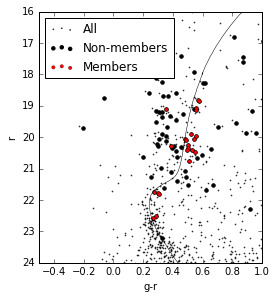

In [36]:
plt.rcParams['figure.figsize'] = 4, 4.5
## plot CMD
def plot_cmd(ra0, dec0, phot_file, spec_file, isochrone, reddening, d_kpc, distance_cut=1./6, two_branches=False):
    # center ra and dec, convert ra from hours to degrees 
    ra = (phot_file[:,1] - ra0)*15 
    dec = phot_file[:,2]
    distance = np.sqrt((ra*np.cos(dec))**2+(dec- dec0)**2)
    
    #apply distance cut
    g = phot_file[:,3][distance<distance_cut]
    r = phot_file[:,5][distance<distance_cut]
    
    # select only points with quality 3 or above
    # select members
    zquality = spec_file.data['ZQUALITY']
    mbr = spec_file.data['MEMBER'] 
    g_spec = spec_file.data['GMAG'][mbr == 1]+(reddening*3.1*1.17)
    r_spec = spec_file.data['RMAG'][mbr == 1]+(reddening*3.1*.86)
    mw_g_spec = spec_file.data['GMAG'][zquality>2]+(reddening*3.1*1.17)
    mw_r_spec = spec_file.data['RMAG'][zquality>2]+(reddening*3.1*.86)

    # extract g-r and r mag from isochrone
    gr_iso = isochrone[:,9]+(reddening*3.1*1.17)-isochrone[:,10]-(reddening*3.1*.86)
    r_iso = isochrone[:,10]+(reddening*3.1*.86)+5*np.log10(d_kpc*100)
    
    # make sure separate tracks not connected
    split = colour_jump(isochrone, 9, 10)
    plt.scatter(g-r, r, c='k', s=0.5, alpha = 0.75, label = 'All')
    plt.scatter(mw_g_spec-mw_r_spec, mw_r_spec, c='k', s=12, label = 'Non-members')
    plt.scatter(g_spec-r_spec, r_spec, c='r', lw=0.25,s=12, label = 'Members')
    plt.plot(gr_iso[0:split], r_iso[0:split], c='k',lw=0.5)
    if two_branches==True:
        plt.plot(gr_iso[split:], r_iso[split:], c='k',lw=0.5)
    plt.xlabel('g-r')
    plt.ylabel('r')
    plt.legend(loc=2)
    plt.xlim(-0.5,1)
    plt.ylim(24,16)

plot_cmd(13.9676111, 12.8552778, boo2_phot, boo2_spec, isochrone_1_5, reddening=boo2_red, d_kpc=42)
plt.savefig('boo2_cmd.png')

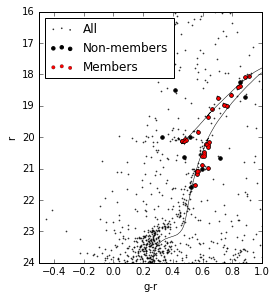

In [40]:
plot_cmd(4.4123611, -21.1875000, eri_phot, eri_spec,isochrone_1_0_11, reddening=eri_red, d_kpc=90., two_branches=True)
plt.figaspect(2.)
plt.savefig('eri_cmd.png')

By eye, the best fit isochrone is [Fe/H] -1.0 at an age of 11 Gyr. Still doesn't fit faintest stars well. Check photometry calibration?

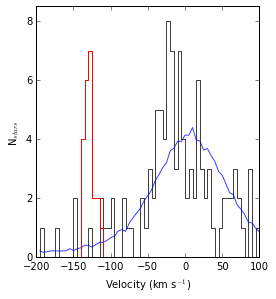

In [56]:
def plot_velocities(spec_file, mwfile, xmin, xmax, ymax, yticks, nbins):
    #read velocities from the Keck file
    mbr = spec_file.data['MEMBER'] 
    v_mbr = (spec_file.data['VCORR'])[mbr == 1]
    v_other = (spec_file.data['VCORR'])[mbr != 1]
    
    #read the MW contaminant file
    mw_mr, mw_g_r = mw_contaminant_cmd(mwfile)
    v_mw = np.genfromtxt(mwfile, usecols=(15))[(mw_mr>17)*(mw_mr<22)] 
    vhist_mbr, vbins = np.histogram(v_mbr, range=(xmin, xmax), bins=nbins)
    vhist_other, vbins = np.histogram(v_other, range=(xmin, xmax), bins=nbins)
    vhist_mw, vbins = np.histogram(v_mw, range=(xmin, xmax), bins=nbins)
    
    #scale the MW histogram so total count matches observed contaminants
    n = sum(vhist_mw) 
    mw_scaled = vhist_mw*sum(vhist_other)/float(n)
    plt.plot(vbins[1:], vhist_other, c='k', alpha=0.75, ls='steps',label='Non-members')
    plt.plot(vbins[1:], mw_scaled, c='b', alpha=0.75, label='MW fit')
    plt.plot(vbins[1:], vhist_mbr, c='r', ls='steps',label='Members')    
    plt.ylim(0,ymax)
    plt.yticks(np.arange(0,ymax,yticks))
    plt.ylabel(r'N$_{stars}$')
    plt.xlabel(r'Velocity (km s$^{-1}$)')

plot_velocities(boo2_spec, 'mw_boo2.dat',-200,100,8.5,2,60)
plt.savefig('boo2_vel.png')

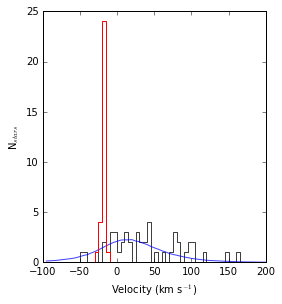

In [57]:
plot_velocities(eri_spec, 'mw_eri.dat',xmin=-100, xmax = 200, ymax=25.01, yticks=5, nbins=60)
plt.savefig('eri_vel.png')
#add milky way contaminants curve 

Mass is calculated either Wolf+ (2010) formula: 3*(sigma^2)*r/G 

or: M(1/2)=930M(sun)*(sigma^2)*r(1/2) 

Above formulae use a 3D velocity dispersion calculated using the method in Walker (2006). 

We work directly with line-of-sight velocity dispersion, so that: 

M = 4*(sigma_los^2)*r/G

In [59]:
#calculate mass, mass-to-light ratio
#propagate asymmetric errors
G = 6.67e-11 #SI units

#calculating mass using Wolf+ 2010 formula
def mass(sigma, r_eff, projected=True):
    #convert to SI units
    sigma0 = sigma[0]*1000 #km/s to m/s
    r_eff0 = r_eff[0]*3.0857e16 #pc to m
    m_kg = 4*(sigma0**2)*r_eff0/G
    if projected == False:
        m_kg*=3./4
    m_sol = m_kg/1.9891e30 #solar masses
    
    # errors added in quadrature
    err_plus = m_sol*np.sqrt((2*sigma[1]/sigma[0])**2+(r_eff[1]/r_eff[0])**2)
    err_minus = m_sol*np.sqrt((2*sigma[2]/sigma[0])**2+(r_eff[2]/r_eff[0])**2) 
    return [m_sol, err_plus, err_minus]

boo2_sigma = [4.3, 1.2, 1.2] #value, +err, -err
boo2_r_eff = [37, 5.5, 5.5]
boo2_L = [1614, 406, 235]
boo2_mass = mass(boo2_sigma, boo2_r_eff)

# dividing mass by luminosity
# can specify if M/L computed in half-mass radius or not
def mass_to_light(mass, luminosity, in_half=True):
    m_l = float(mass[0])/luminosity[0]
    if in_half==False:
        m_l *= 2
    # errors added in quadrature
    err_plus = m_l*np.sqrt((float(mass[1])/float(mass[0]))**2+(luminosity[1]/luminosity[0])**2)
    err_minus = m_l*np.sqrt((float(mass[2])/float(mass[0]))**2+(luminosity[2]/luminosity[0])**2)    
    return [m_l, err_plus, err_minus]

Now computing mass, mass-to-light and errors for our observations 

In [60]:
boo2_m_l = mass_to_light(boo2_mass, boo2_L)
print 'Mass: ',['%0.2e' % elt for elt in boo2_mass]
print 'M/L: ',['%i' % elt for elt in boo2_m_l]

Mass:  ['6.36e+05', '3.68e+05', '3.68e+05']
M/L:  ['394', '227', '227']


In [61]:
eri_sigma = [0.7,0,0] #is this how to deal with an upper bound??
eri_r_eff = [16.7, 1.1, 1.1]
eri_L = [9817, 1187, 900]
eri_mass = mass(eri_sigma, eri_r_eff)
eri_m_l = mass_to_light(eri_mass, eri_L)
print 'Mass: ', ['%0.2e' % elt for elt in eri_mass]
print 'M/L: ', ['%0.2e' % elt for elt in eri_m_l]

Mass:  ['7.61e+03', '5.01e+02', '5.01e+02']
M/L:  ['7.75e-01', '5.11e-02', '5.11e-02']


In [72]:
#test against Simon et al 2015 Ret II paper
ret_sigma = [3.3,0.7,0.7] #is this how to deal with an upper bound??
ret_r_eff = [55, 5, 5]
ret_L = [2360, 217, 217]
#dL/L = -0.92*dM = -.092
ret_mass = mass(ret_sigma, ret_r_eff)
ret_m_l = mass_to_light(ret_mass, ret_L)
print 'Mass: ', ['%0.2e' % elt for elt in ret_mass]
print 'M/L: ', ['%i' % elt for elt in ret_m_l]

Mass:  ['5.57e+05', '2.36e+05', '2.36e+05']
M/L:  ['236', '100', '100']


Published

Mass: 5.6e+5 +/- 2.4e+5

M/L: 470+/-210

Consistent!

In [71]:
#test against Fadely et al 2011 Seg 3 paper
print 'This paper only published M/L. I get:'
seg_sigma = [1.2,2.6,2.6] 
seg_r_eff = [2.1,0.4,0.4]
seg_L = [89, 93, 45]
seg_mass = mass(seg_sigma, seg_r_eff)
seg_m_l = mass_to_light(seg_mass, seg_L, in_half=True)
print 'Using Plummer profile : ', ['%i' % elt for elt in seg_m_l]
seg_r_eff = [2.2,0.7,0.7]
seg_L = [90, 95, 56]
seg_mass = mass(seg_sigma, seg_r_eff)
seg_m_l = mass_to_light(seg_mass, seg_L, in_half=True)
print 'Using Exponential profile : ', ['%i' % elt for elt in seg_m_l]

This paper only published M/L. I get:
Using Plummer profile :  ['31', '140', '137']
Using Exponential profile :  ['32', '146', '142']


Published : [33, +156, -144]
    
Consistent, but not exact match. Why?

In [69]:
# Simon+2011 Seg 1
# formula in paper: Wolf 
L = [340,250,188]
r_eff = [29,8,5]
sigma = [3.7,1.4,1.1]#or [3.4,0.9,0.9] after removing binaries, etc
print 'Mass: ', ['%0.2e' % elt for elt in np.array(mass(sigma, r_eff, projected=False))]
print 'M/L: ', ['%i' % elt for elt in np.array(mass_to_light(mass(sigma, r_eff), L, in_half=True))]

Mass:  ['2.77e+05', '2.10e+05', '1.65e+05']
M/L:  ['1086', '822', '645']


This paper used a Bayesian prior to compute best fit mass and 1-sigma errors. Published:

Mass: 5.8e+5 +8.6e+5 -3.1e+5 M_sun

M/L: 3400 in half-light radius

I don't understand how this M/L is computed

In [68]:
#test against Koposov+ 2015 Ret II
def M_to_L(M):
    return pow(10,(4.77-M)/2.5)
M = [-2.7,-2.6,-2.8]
L_temp = M_to_L(M[0])
L = [L_temp,L_temp*(-0.92)*M[2],L_temp*(-0.92)*M[1]]
r_eff = [32,1.9,1.1]
sigma = [3.22,1.64,0.49]
print 'Mass: ', ['%0.2e' % elt for elt in mass(sigma, r_eff)]
print 'M/L: ', ['%i' % elt for elt in mass_to_light(mass(sigma, r_eff), L, in_half=True)]

Mass:  ['3.09e+05', '3.15e+05', '9.45e+04']
M/L:  ['317', '879', '765']


Claim to use mass formula from Wolf+ 2010! Published:

Mass: [2.35 +4.71 -0.13]e+5 M{sun}

M/L: 479 +904 -51

In [67]:
#test against Koposov+ 2015 Hor I
M = [-3.4,-3.3,-3.5]
L_temp = M_to_L(np.asarray(M))
L = [L_temp[0],L_temp[2]-L_temp[0],L_temp[0]-L_temp[1]]
r_eff = [30,4.4,3.3]
sigma = [4.9,2.8,0.9]
print 'Mass: ', ['%0.2e' % elt for elt in mass(sigma, r_eff)]
print 'M/L: ', ['%i' % elt for elt in mass_to_light(mass(sigma, r_eff), L, in_half=True)]

mass:  ['6.70e+05', '7.72e+05', '2.57e+05']
M/L:  ['361', '418', '142']


Published:

Mass: [5.5 +11 -1]e+5 M{sun}
    
M/L: 570 +1154 -112